dSA preselections

In [1]:
from coffea import hist
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt
import awkward
from uproot_methods import TLorentzVectorArray

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
import os
from os.path import join

dataset4mu_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu_v2.json')))
dataset2mu2e_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e_v2.json')))

In [3]:
class dsaCutsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        ptreso_axis = hist.Bin('ptreso', '$(p_T^{reco}-p_T^{gen})/p_T^{gen}$', 50, -1, 1)
        numhit_axis = hist.Bin('nhit', '# valid hits', 50, 0, 50)
        numsta_axis = hist.Bin('nsta', '# valid stations', 5, 0, 5)
        errpt_axis = hist.Bin('errpt', '$\sigma_{p_T}/p_T$', 20, 0, 5)
        qdiff_axis = hist.Bin('qdiff', '$q^{reco}-q^{gen}$', 5, -2, 3)
        self._accumulator = processor.dict_accumulator({
            'dsa': hist.Hist('Counts', dataset_axis, ptreso_axis, numhit_axis, numsta_axis, errpt_axis, qdiff_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        dsamuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['dsamuon_p4.fCoordinates.fX'],
                                                 df['dsamuon_p4.fCoordinates.fY'],
                                                 df['dsamuon_p4.fCoordinates.fZ'],
                                                 df['dsamuon_p4.fCoordinates.fT']),
            numhits=df['dsamuon_nValStaHits'],
            numstas=df['dsamuon_nStaValHits'],
            cschits=df['dsamuon_nValCSCHits'],
            dthits=df['dsamuon_nValDTHits'],
            cscstas=df['dsamuon_nValCSCStas'],
            dtstas=df['dsamuon_nValDTStas'],
            pterr=df['dsamuon_ptErr'],
            charge=df['dsamuon_charge'],
        )
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
            charge=df['gen_charge'],
        )
        genmuons = genparticles[np.abs(genparticles.pid)==13]


        dsamuons.add_attributes(matchedidx = dsamuons.argmatch(genmuons, deltaRCut=0.2))
        matcheddsa = dsamuons[dsamuons.matchedidx!=-1]
        matchedgenmu = genmuons[matcheddsa.matchedidx]
        
        output['dsa'].fill(dataset=dataset,
                           ptreso=((matcheddsa.pt-matchedgenmu.pt)/matchedgenmu.pt).flatten(),
                           nhit=(matcheddsa.cschits+matcheddsa.dthits).flatten(),
                           nsta=(matcheddsa.cscstas+matcheddsa.dtstas).flatten(),
                           errpt=(matcheddsa.pterr/matcheddsa.pt).flatten(),
                           qdiff=(matcheddsa.charge-matchedgenmu.charge).flatten()
                          )
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [15]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

# dataset={
#     '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
#     '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
#     '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
# }

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=dsaCutsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:06<00:00,  3.11items/s]


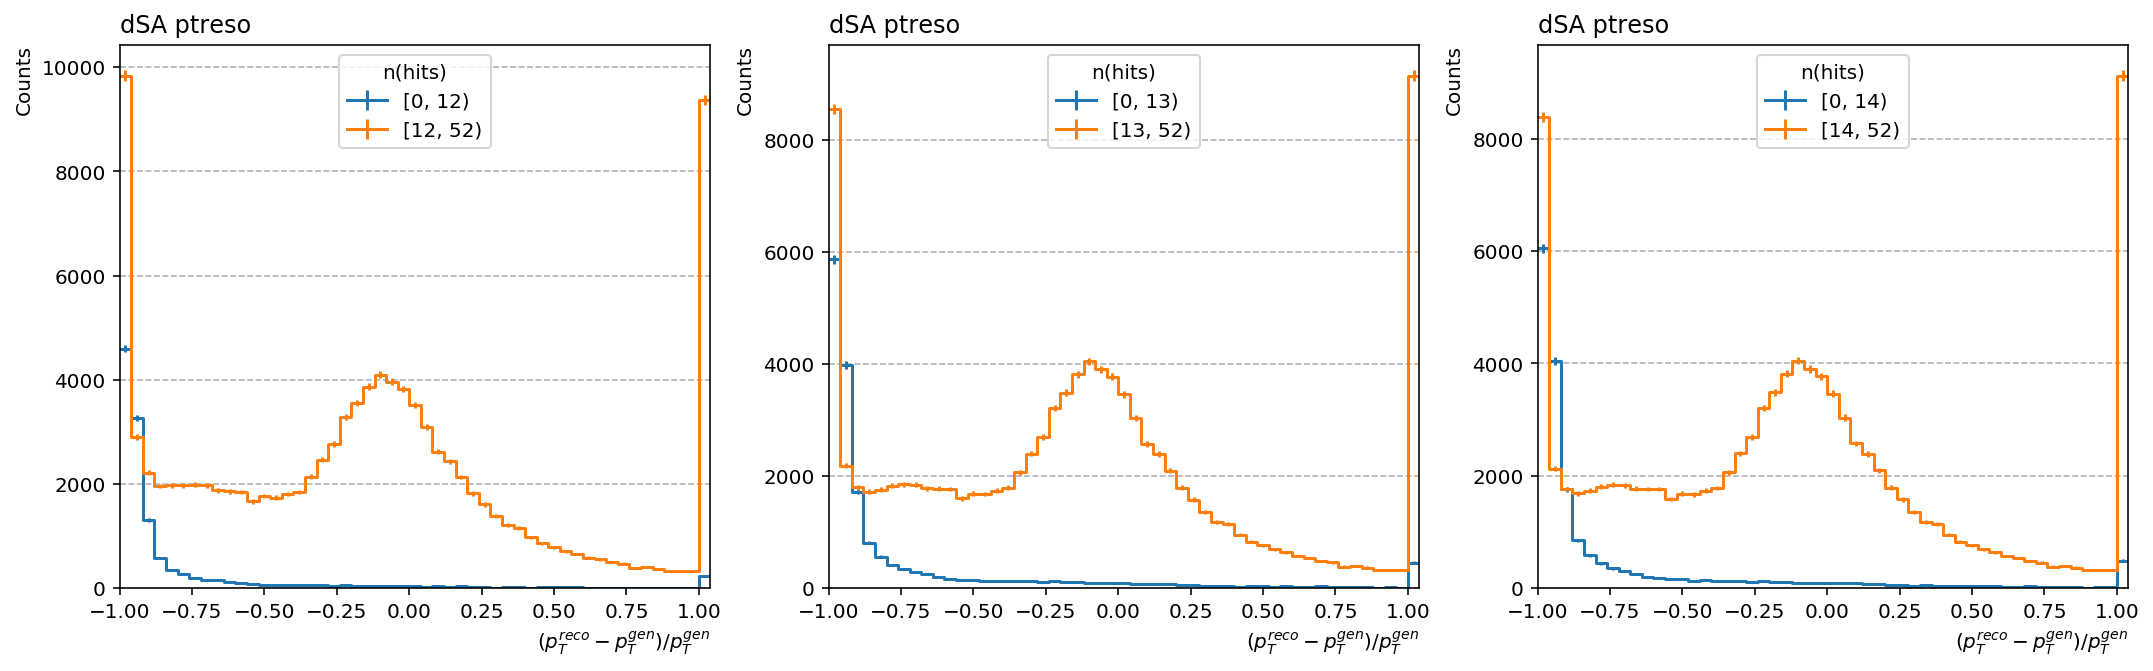

In [16]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
h_ = output['dsa'].integrate('dataset').integrate('nsta').integrate('qdiff').integrate('errpt')
metric = 13
h0 = h_.rebin('nhit', hist.Bin('nhit_', 'n(hits)', [0, metric-1, 52]))
h1 = h_.rebin('nhit', hist.Bin('nhit_', 'n(hits)', [0, metric, 52]))
h2 = h_.rebin('nhit', hist.Bin('nhit_', 'n(hits)', [0, metric+1, 52]))
hist.plot1d(h0, overlay='nhit_', overflow='over', ax=axes[0], density=False)
hist.plot1d(h1, overlay='nhit_', overflow='over', ax=axes[1], density=False)
hist.plot1d(h2, overlay='nhit_', overflow='over', ax=axes[2], density=False)
for ax in axes.flat:
#     ax.set_ylim([0, 2000])
    ax.grid(axis='y', ls='--')
    ax.set_title('dSA ptreso', ha='left', x=0)
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

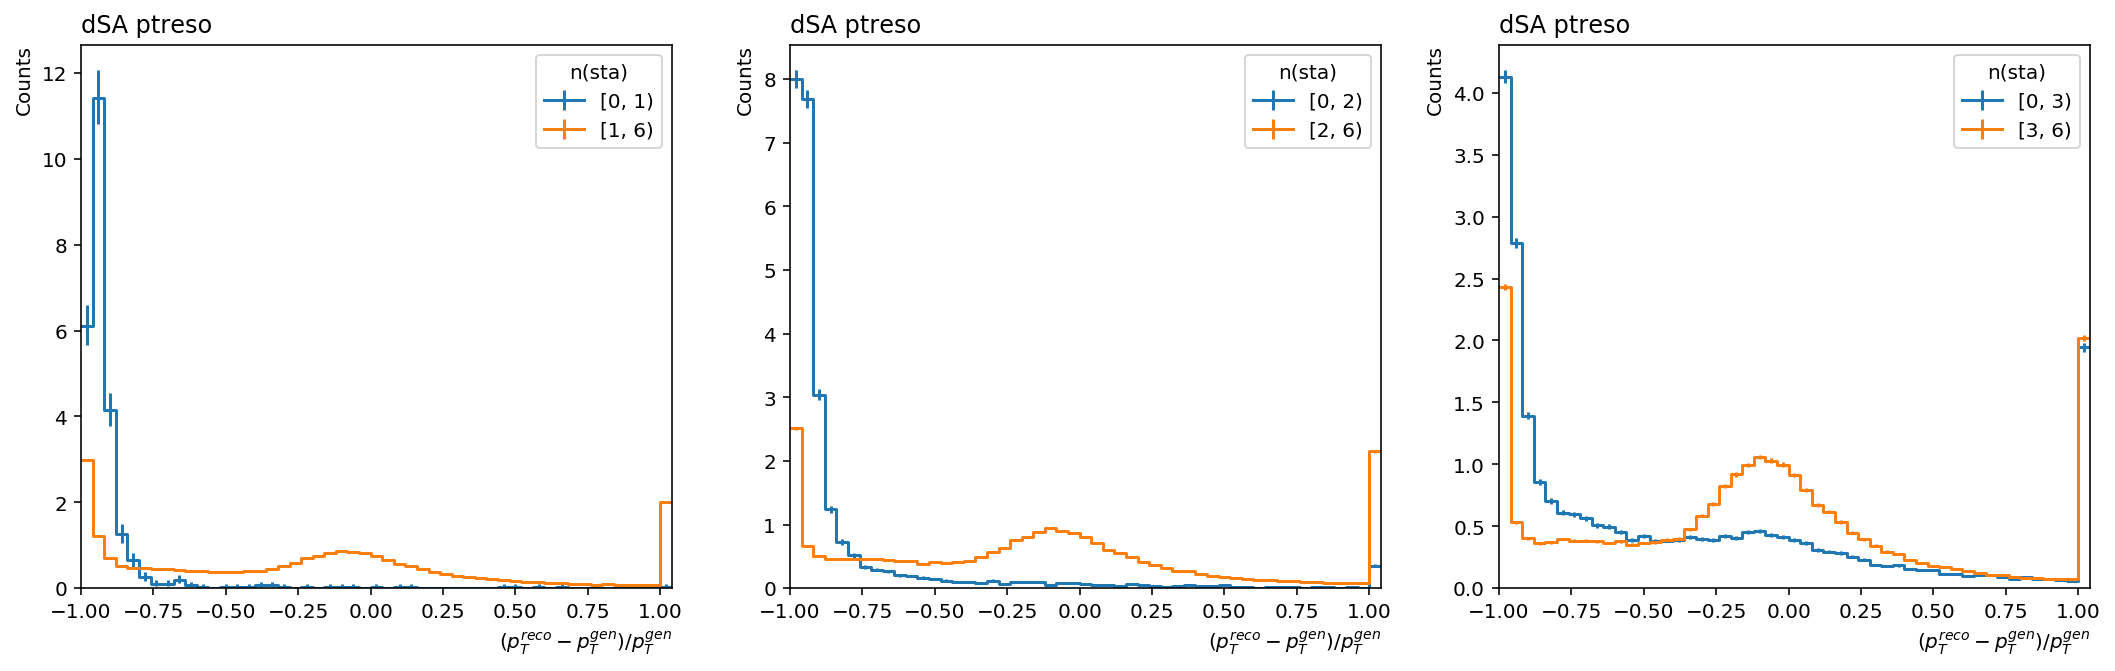

In [17]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
h_ = output['dsa'].integrate('dataset').integrate('nhit').integrate('qdiff').integrate('errpt')
metric = 2
h0 = h_.rebin('nsta', hist.Bin('nsta_', 'n(sta)', [0, metric-1, 6]))
h1 = h_.rebin('nsta', hist.Bin('nsta_', 'n(sta)', [0, metric, 6]))
h2 = h_.rebin('nsta', hist.Bin('nsta_', 'n(sta)', [0, metric+1, 6]))
hist.plot1d(h0, overlay='nsta_', overflow='over', ax=axes[0], density=True)
hist.plot1d(h1, overlay='nsta_', overflow='over', ax=axes[1], density=True)
hist.plot1d(h2, overlay='nsta_', overflow='over', ax=axes[2], density=True)
for ax in axes.flat:
    ax.set_title('dSA ptreso', ha='left', x=0)
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

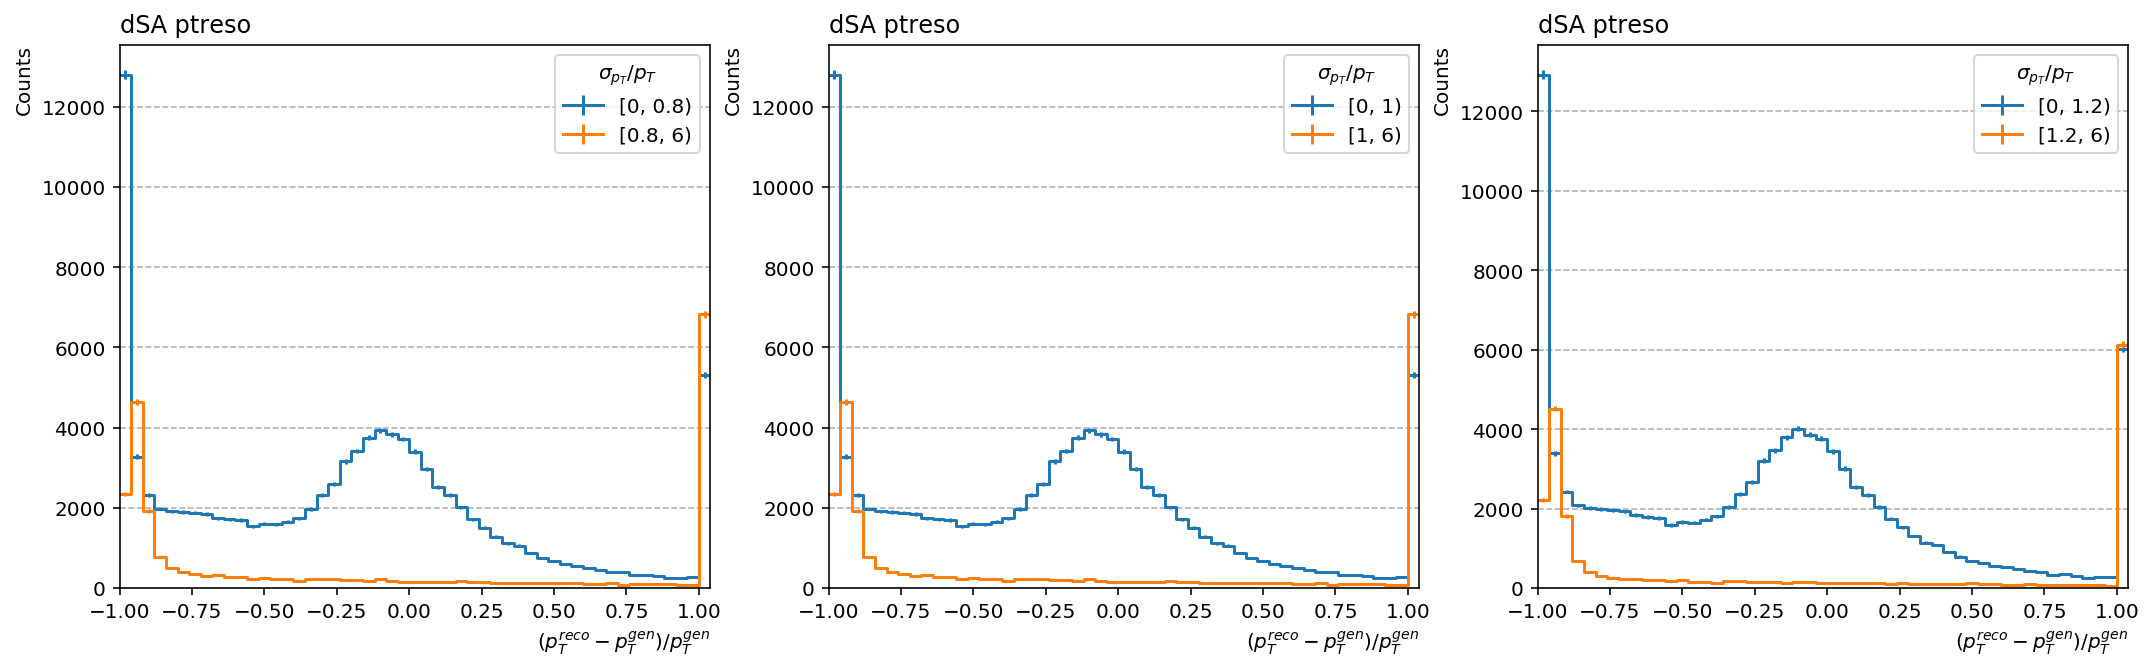

In [18]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
h_ = output['dsa'].integrate('dataset').integrate('nhit').integrate('qdiff').integrate('nsta')
metric = 1.
h0 = h_.rebin('errpt', hist.Bin('errpt_', '$\sigma_{p_T}/p_T$', [0, metric-0.2, 6]))
h1 = h_.rebin('errpt', hist.Bin('errpt_', '$\sigma_{p_T}/p_T$', [0, metric,     6]))
h2 = h_.rebin('errpt', hist.Bin('errpt_', '$\sigma_{p_T}/p_T$', [0, metric+0.2, 6]))
hist.plot1d(h0, overlay='errpt_', overflow='over', ax=axes[0], density=False)
hist.plot1d(h1, overlay='errpt_', overflow='over', ax=axes[1], density=False)
hist.plot1d(h2, overlay='errpt_', overflow='over', ax=axes[2], density=False)
for ax in axes.flat:
#     ax.set_ylim([0, 7000])
    ax.grid(axis='y', ls='--')
    ax.set_title('dSA ptreso', ha='left', x=0)
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

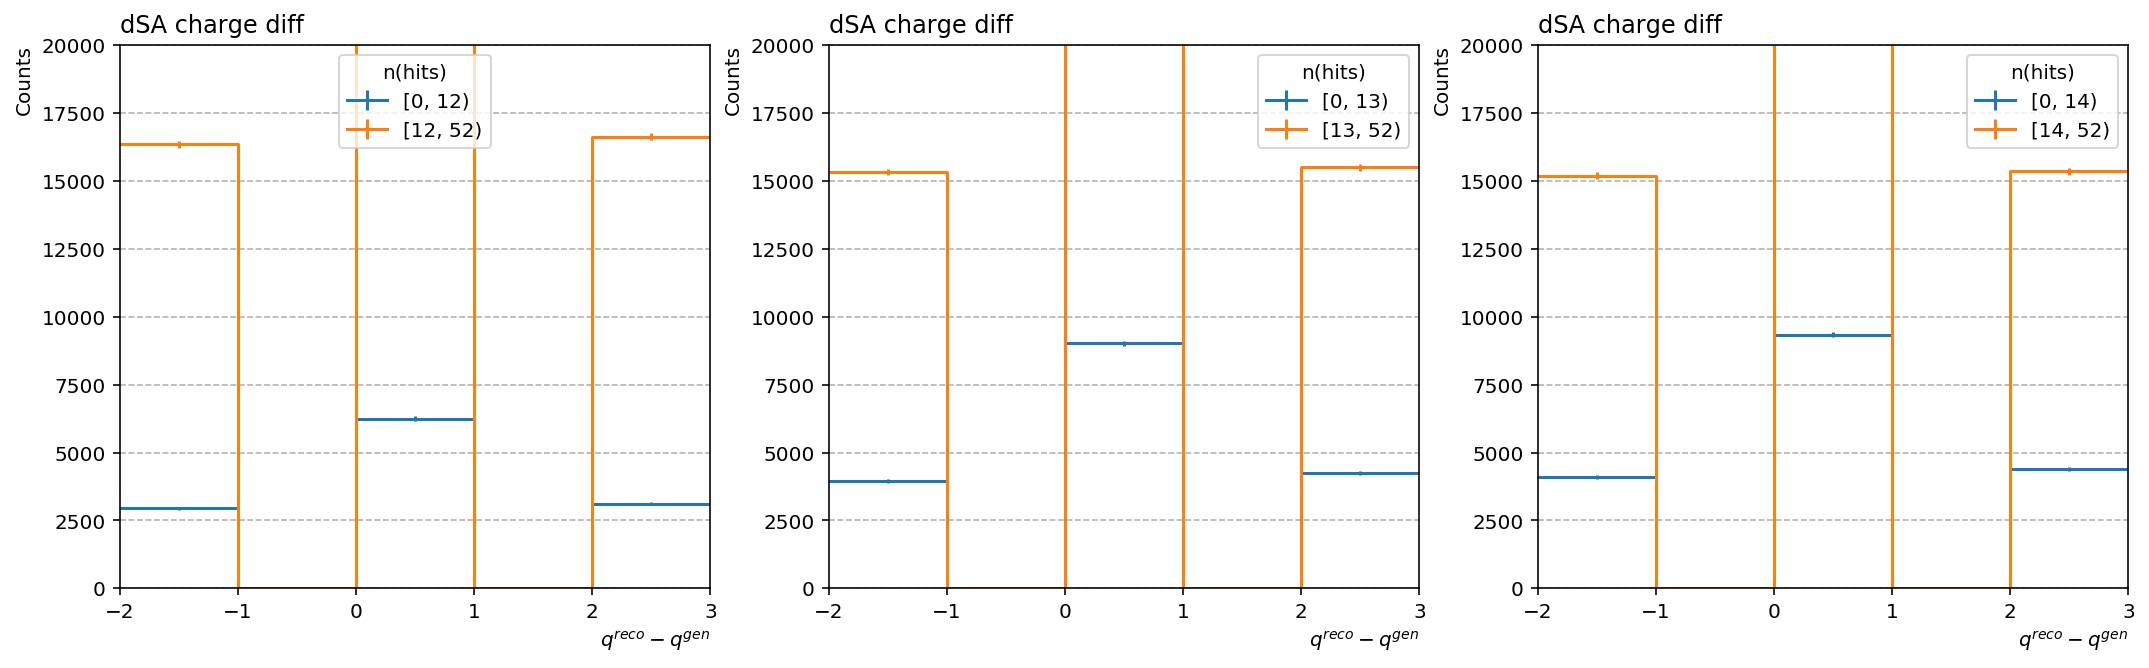

In [19]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
h_ = output['dsa'].integrate('dataset').integrate('nsta').integrate('ptreso').integrate('errpt')
metric = 13
h0 = h_.rebin('nhit', hist.Bin('nhit_', 'n(hits)', [0, metric-1, 52]))
h1 = h_.rebin('nhit', hist.Bin('nhit_', 'n(hits)', [0, metric, 52]))
h2 = h_.rebin('nhit', hist.Bin('nhit_', 'n(hits)', [0, metric+1, 52]))
hist.plot1d(h0, overlay='nhit_', ax=axes[0], density=False)
hist.plot1d(h1, overlay='nhit_', ax=axes[1], density=False)
hist.plot1d(h2, overlay='nhit_', ax=axes[2], density=False)
for ax in axes.flat:
    ax.set_ylim([0, 20000])
    ax.grid(axis='y', ls='--')
    ax.set_title('dSA charge diff', ha='left', x=0)
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

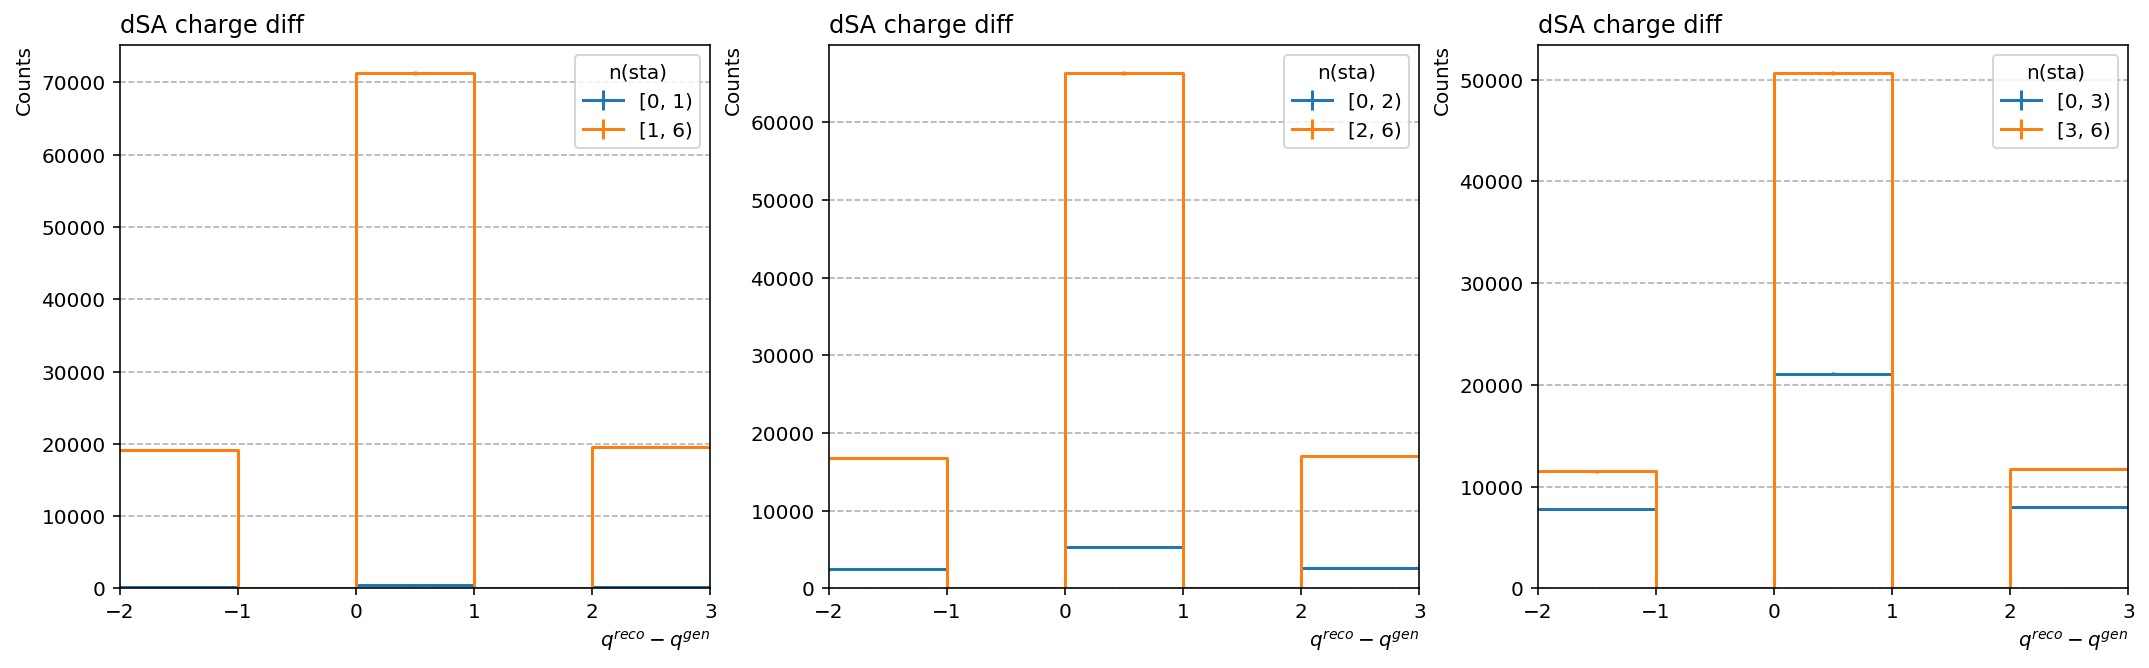

In [20]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
h_ = output['dsa'].integrate('dataset').integrate('nhit').integrate('ptreso').integrate('errpt')
metric = 2
h0 = h_.rebin('nsta', hist.Bin('nsta_', 'n(sta)', [0, metric-1, 6]))
h1 = h_.rebin('nsta', hist.Bin('nsta_', 'n(sta)', [0, metric, 6]))
h2 = h_.rebin('nsta', hist.Bin('nsta_', 'n(sta)', [0, metric+1, 6]))
hist.plot1d(h0, overlay='nsta_', ax=axes[0], density=False)
hist.plot1d(h1, overlay='nsta_', ax=axes[1], density=False)
hist.plot1d(h2, overlay='nsta_', ax=axes[2], density=False)
for ax in axes.flat:
#     ax.set_ylim([0, 4000])
    ax.grid(axis='y', ls='--')
    ax.set_title('dSA charge diff', ha='left', x=0)
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

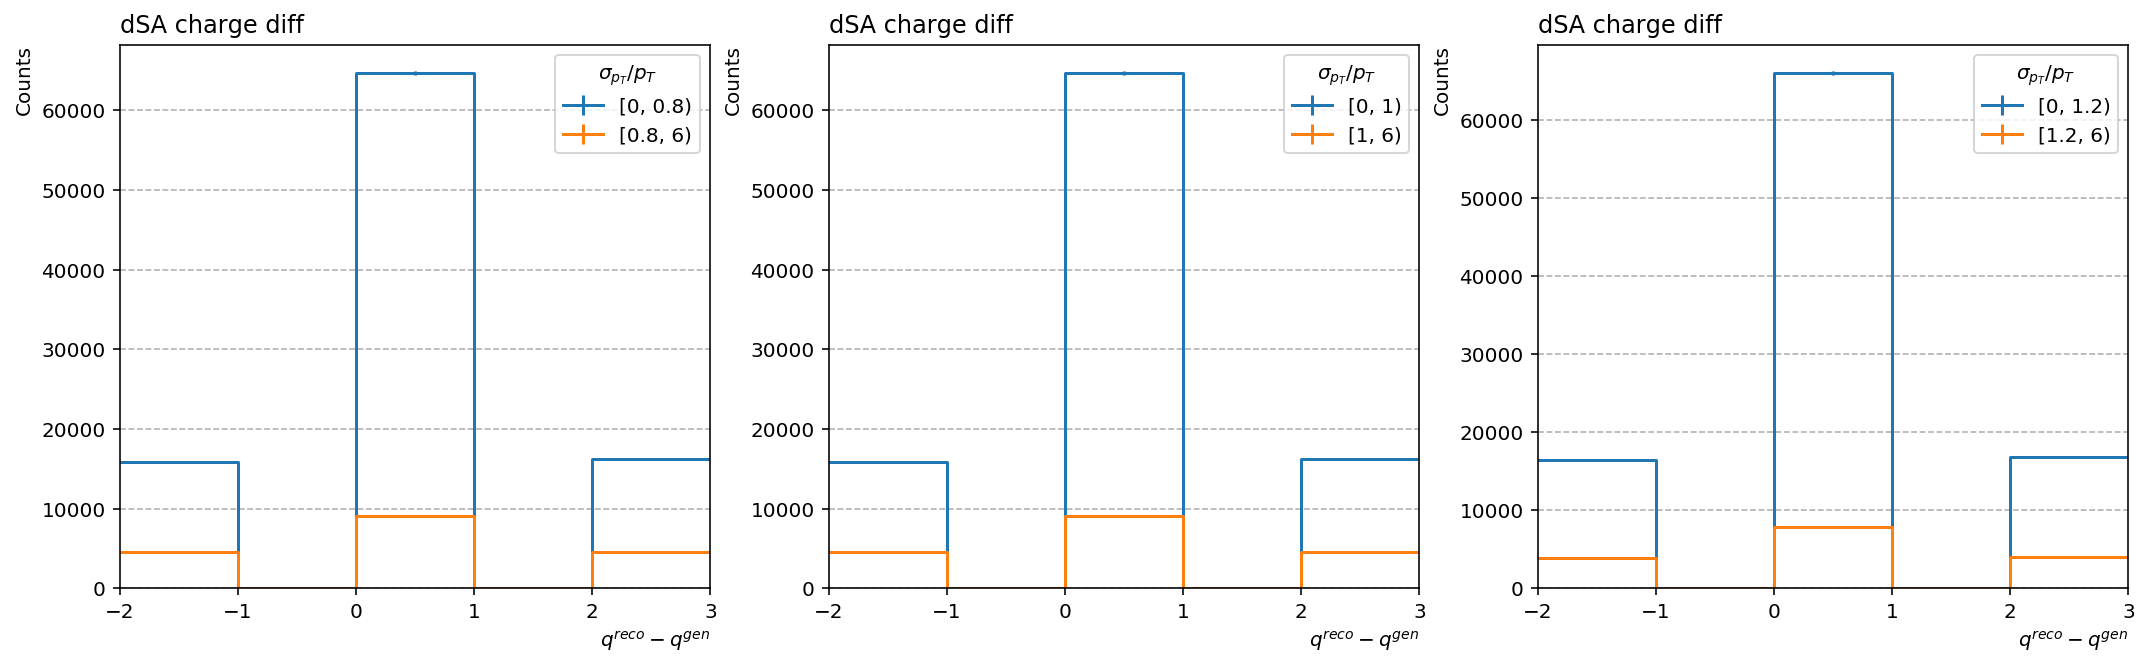

In [21]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
h_ = output['dsa'].integrate('dataset').integrate('nhit').integrate('ptreso').integrate('nsta')
metric = 1.
h0 = h_.rebin('errpt', hist.Bin('errpt_', '$\sigma_{p_T}/p_T$', [0, metric-0.2, 6]))
h1 = h_.rebin('errpt', hist.Bin('errpt_', '$\sigma_{p_T}/p_T$', [0, metric,     6]))
h2 = h_.rebin('errpt', hist.Bin('errpt_', '$\sigma_{p_T}/p_T$', [0, metric+0.2, 6]))
hist.plot1d(h0, overlay='errpt_', overflow='none', ax=axes[0], density=False)
hist.plot1d(h1, overlay='errpt_', overflow='none', ax=axes[1], density=False)
hist.plot1d(h2, overlay='errpt_', overflow='none', ax=axes[2], density=False)
for ax in axes.flat:
#     ax.set_ylim([0, 10000])
    ax.grid(axis='y', ls='--')
    ax.set_title('dSA charge diff', ha='left', x=0)
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [34]:
class dsaCutsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        ptreso_axis = hist.Bin('ptreso', '$(p_T^{reco}-p_T^{gen})/p_T^{gen}$', 50, -1, 1)
        dsaid_axis = hist.Bin('dsaid', 'pass id', 2, 0, 2)
#         numhit_axis = hist.Bin('nhit', '# valid hits', 50, 0, 50)
#         numsta_axis = hist.Bin('nsta', '# valid stations', 5, 0, 5)
#         errpt_axis = hist.Bin('errpt', '$\sigma_{p_T}/p_T$', 20, 0, 5)
#         qdiff_axis = hist.Bin('qdiff', '$q^{reco}-q^{gen}$', 5, -2, 3)
        self._accumulator = processor.dict_accumulator({
            'dsa': hist.Hist('Counts', dataset_axis, ptreso_axis, dsaid_axis,),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        dsamuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['dsamuon_p4.fCoordinates.fX'],
                                                 df['dsamuon_p4.fCoordinates.fY'],
                                                 df['dsamuon_p4.fCoordinates.fZ'],
                                                 df['dsamuon_p4.fCoordinates.fT']),
            numhits=df['dsamuon_nValStaHits'],
            numstas=df['dsamuon_nStaValHits'],
            cschits=df['dsamuon_nValCSCHits'],
            dthits=df['dsamuon_nValDTHits'],
            cscstas=df['dsamuon_nValCSCStas'],
            dtstas=df['dsamuon_nValDTStas'],
            pterr=df['dsamuon_ptErr'],
            charge=df['dsamuon_charge'],
        )
        dsaid=((dsamuons.cschits+dsamuons.dthits)>12)&((dsamuons.cscstas+dsamuons.dtstas)>1)&((dsamuons.pterr/dsamuons.pt)<1)
        dsamuons.add_attributes(dsaid=dsaid)
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
            charge=df['gen_charge'],
        )
        genmuons = genparticles[np.abs(genparticles.pid)==13]


        dsamuons.add_attributes(matchedidx = dsamuons.argmatch(genmuons, deltaRCut=0.2))
        matcheddsa = dsamuons[dsamuons.matchedidx!=-1]
        matchedgenmu = genmuons[matcheddsa.matchedidx]
        
        output['dsa'].fill(dataset=dataset,
                           ptreso=((matcheddsa.pt-matchedgenmu.pt)/matchedgenmu.pt).flatten(),
                           dsaid = matcheddsa.dsaid.flatten(),
                          )
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [35]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=dsaCutsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:05<00:00,  3.99items/s]


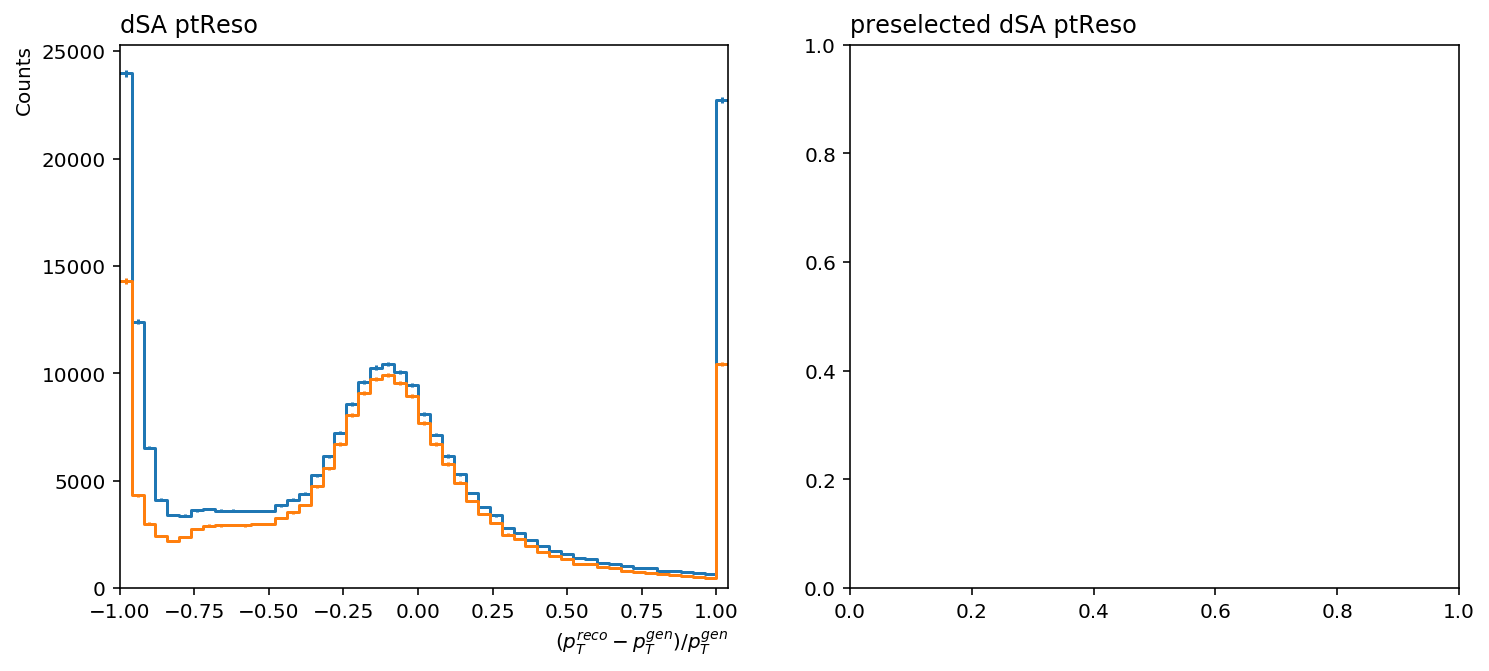

In [36]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
hist.plot1d(output['dsa'].integrate('dsaid').integrate('dataset'), ax=axes[0], overflow='over')
hist.plot1d(output['dsa'].integrate('dsaid', slice(1,2)).integrate('dataset'), ax=axes[0], overflow='over', clear=False)

axes[0].set_title('dSA ptReso', ha='left', x=0)
axes[1].set_title('preselected dSA ptReso', ha='left', x=0)
for ax in axes.flat:
#     ax.set_ylim([0, 4000])
#     ax.grid(axis='y', ls='--')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");